# Demonstration: Log/Log and Semi-Log plots

First we have our standard header with common import statements, and a statement to make plots look nice.

In [1]:
# standard import statements
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as opt

import classlib4334

# jupyter-specific display instructions
mpl.rcParams['font.size'] = 11
mpl.rcParams['lines.linewidth'] = 2
%config InlineBackend.figure_format = 'retina'

We are going to fit several things to lines here, so we'll define a line function once to re-use throughout the exercise.

## Visualization and Brainstorming

In [2]:
excel_file = 'data/demo-powerlaw-1.xlsx'
mydata = pd.read_excel(excel_file)
x1 = np.array(mydata['x'])
y1 = np.array(mydata['y'])

mydata.head()

,Unnamed: 0,x,y
0,0,1.000000,2.765743
1,1,1.584893,2.963795
2,2,2.511886,2.185764
3,3,3.981072,3.601706
4,4,6.309573,5.103419


First, let's plot the original data.

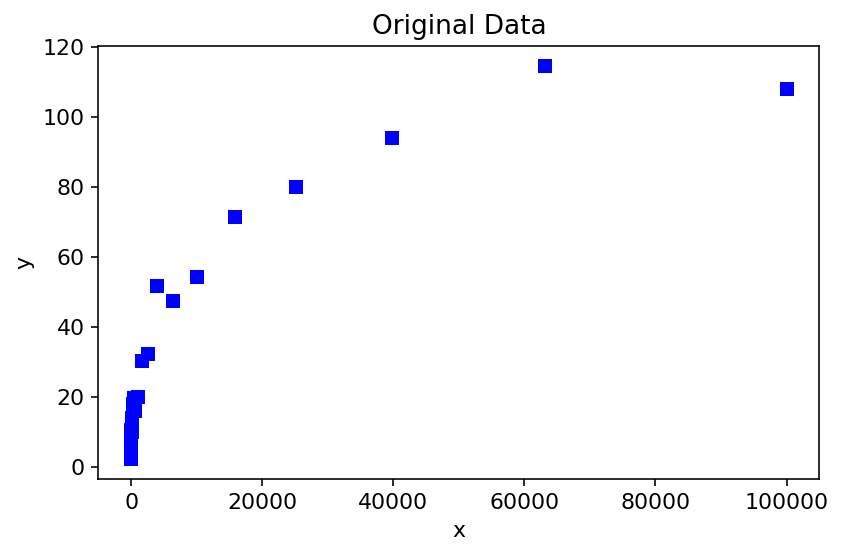

In [3]:
plt.figure()

plt.plot(x1,y1, 'bs')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Original Data')

plt.tight_layout()
plt.show()

We see several features in this data.

First, the data points are clustered largely at the lower-left end of the plot, with only a few points in the upper-right.  Second, we see that the data seems to span quite a few orders of magnitude:  several values of x seem to be as small as 1, whereas the largest value of x is about 100,000.  This brings us to an important rule of thumb in data analysis:

***"When a variable spans many orders of magnitude, try taking its logarithm."***

So, let's plot the logarithm of x vs y.

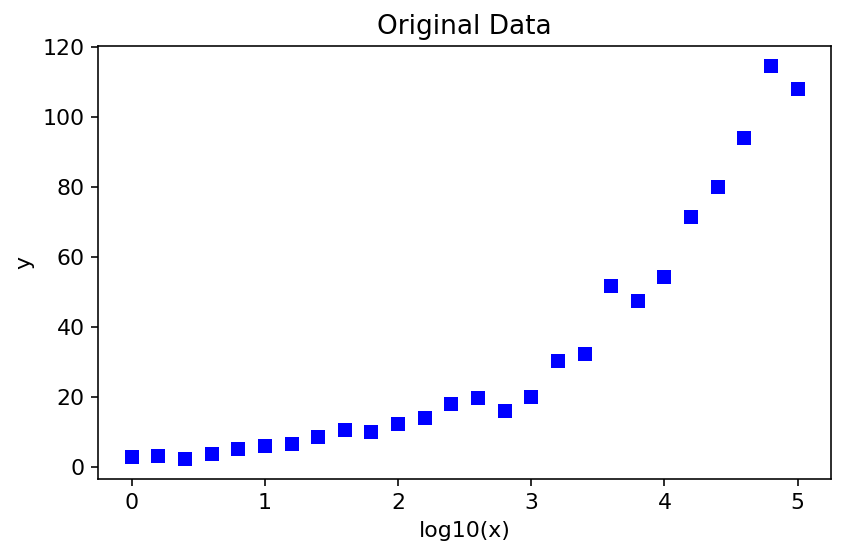

In [3]:
plt.figure()

plt.plot(np.log10(x1), y1, 'bs')
plt.xlabel('log10(x)')
plt.ylabel('y')
plt.title(r'Original Data')

plt.tight_layout()
plt.show()

Okay, the data appear much more nicely spaced out!  (Note that we took ***base 10*** logarithm, because people have an intuitive understanding of powers of 10, rather than powers of $e$).  Indeed, from an experimental / sampling perspective, it often makes sense to spread measurements / samples *evenly over the powers of 10*, rather than evenly in the numbers themselves.  And such spreads are common in many areas of science, such as astronomy (star masses range from about 0.7 solar masses to tens of thousands of solar masses) and biology (animal masses range from a few grams to millions of grams).  So the rule of thumb described above can often come into play.

Now, we could fit the data in this form, perhaps a polynomial.  But this would give us a polynomial in powers of **log10(x)**, which is a bit awkward.  And we see that the data also spans at least three orders of magnitude in $y$.  So before we attempt to come up with a model, let's also try taking the logarithm of $y$.

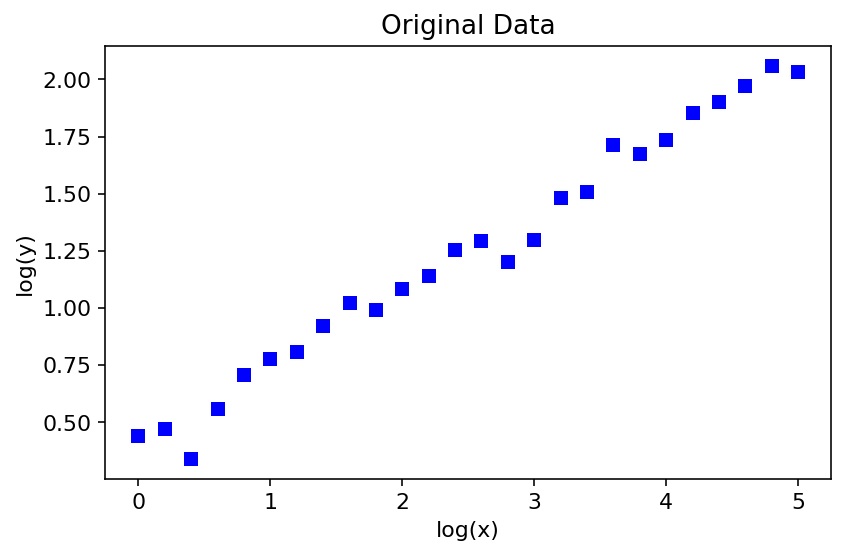

In [4]:
plt.figure()

plt.plot(np.log10(x1), np.log10(y1), 'bs')
plt.xlabel('log(x)')
plt.ylabel('log(y)')
plt.title(r'Original Data')

plt.tight_layout()
plt.show()

Aha!  Now the data appear very nearly linear.  This is aesthetically pleasing, but also suggests that there may be a relatively simple pattern hiding within data that initially appeared to be somewhat complex.

# Idea 1:  Fit a line to the transformed data

One approach is to simply fit the transformed data to a line, with the form

$\log_{10}(y) = a + b \log_{10}(x)$

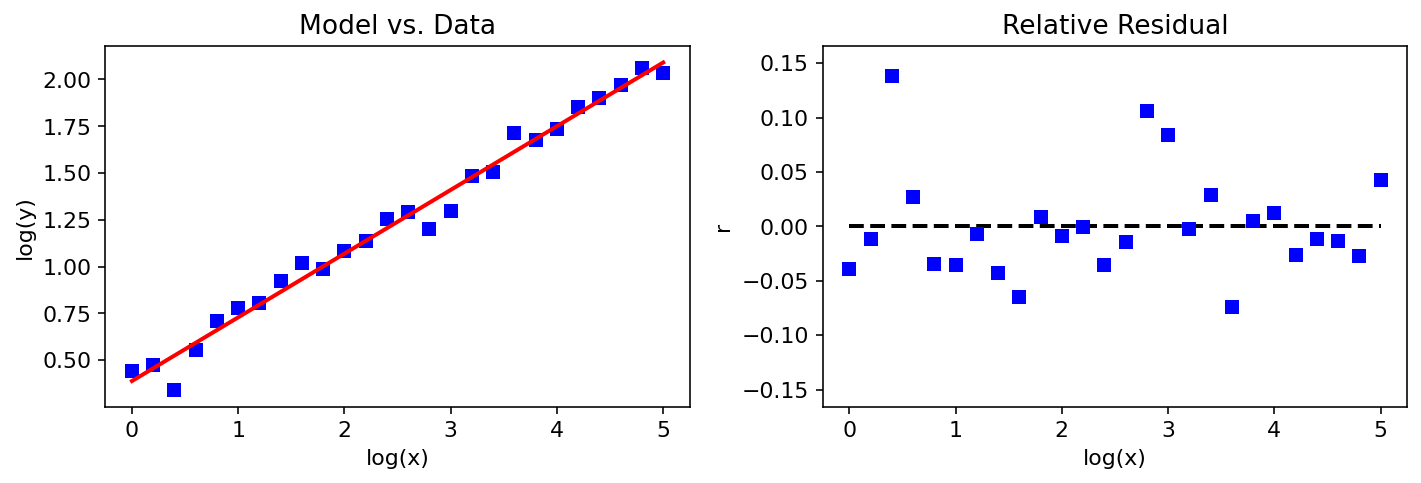

Parameter Values: 95%

   a =   0.388714 +- 0.051228
   b =   0.340389 +- 0.017571

absolute r-squared: 0.98426356  (1.80 nines)
adjusted r-squared: 0.98360788  (1.79 nines)




In [6]:
def line(x, a, b):
    return a + b*x

tx1 = np.log10(x1)
ty1 = np.log10(y1)

# fit transformed data to a line, get predictions
linguess = [0.4, 0.3]  
linfit, linerr = classlib4334.fit_and_plot(line, tx1, ty1, xlabel="log(x)", ylabel="log(y)")

a_lin = linfit[0]
b_lin = linfit[1]

This looks okay.  The residual looks pretty random.  So it seems good.  The last step is then to try and solve for the original variable $y$.  This can be done in a few simple steps that rely on the rules of logarithms:
$$\log_{10}(y) = A + B \log_{10}(x)$$
$$\log_{10}(y) = A + \log_{10}(x^B)$$
$$\log_{10}(y) = \log_{10}(10^A) + \log_{10}(x^B)$$
$$\log_{10}(y) = \log_{10}(10^A x^B)$$

At this point, we can raise 10 to the power of each side, and solve for $y$ itself to obtain
$$ y = 10^A x^B$$
We could call this the **inverse transformed model**, and we can plot it against the original data.

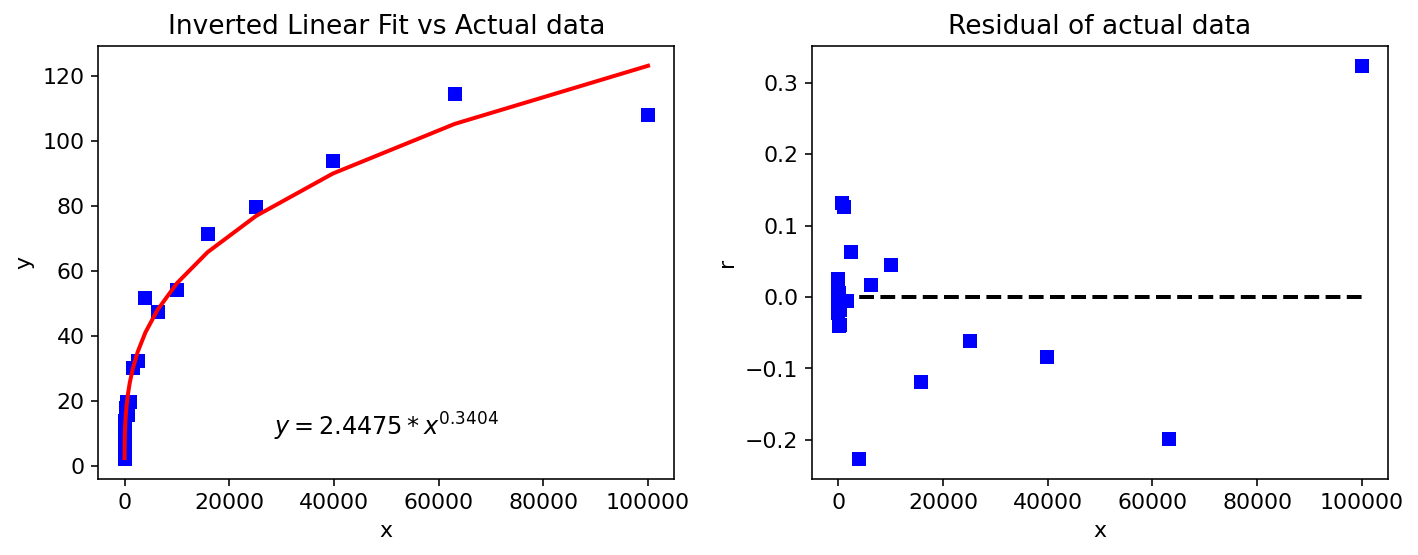

In [7]:
# Solve for the model that would describe the original data
ypred = 10**a_lin * x1 ** b_lin
ypred_string = r"$y = %1.4f * x ^ {%1.4f}$" % (10**a_lin, b_lin)

yrms = np.sqrt(np.mean(y1**2))

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(x1, y1, 'bs')
plt.plot(x1, ypred, 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Inverted Linear Fit vs Actual data')
plt.text(0.5, 0.1, ypred_string, {'size':12}, horizontalalignment="center", transform=plt.gca().transAxes)

plt.subplot(122)
plt.plot(x1,0*x1, 'k--')
plt.plot(x1, (ypred-y1)/yrms, 'bs')
plt.xlabel('x')
plt.ylabel('r')
plt.title(r'Residual of actual data')

plt.tight_layout()
plt.show()

This looks reasonable. It is a bit concerning that the last two data points exhibit such large deviations from our model -- indeed, the last data point has a lower value than the second-to-last data point. However, even though they take up a lot of space on the graph, and have the largest values, these are still **just two** data points. So we need to keep that perspective. Moreover, because of the structure of the log/log plot, we suspect that the noise may be multiplicative, which means we would expect larger absolute deviations for data points with larger values.

In this context, it's not too much of a stretch to imagine that the second-to-last point might simply be unusually high, and the last one unusually low. The log/log plot is invaluable for offering this perspective when noise is multiplicative.

This looks quite good, with a nice clean residual.  However, let's just do one more check -- let's fit the original data to the nonlinear power law function.  Because this funciton is nonlinear, it is wise to give it a good initial guess, and we'll use the coefficients that we obtained from the previous process.

# Idea 2:  Fit a power law to the original data 

But if the result of the above process was just a power law model, why not simply feed that function to curve_fit() and be done with it?  

Twenty years ago, an obvious response would be that the power law function is nonlinear in the parameters, and therefore cannot be optimized by hand, whereas lines are linear in the paramters, and therefore can be optimized by hand.  However, we aren't doing this by hand, so why not just use the nonlinear function to start with?

Okay, let's try it!


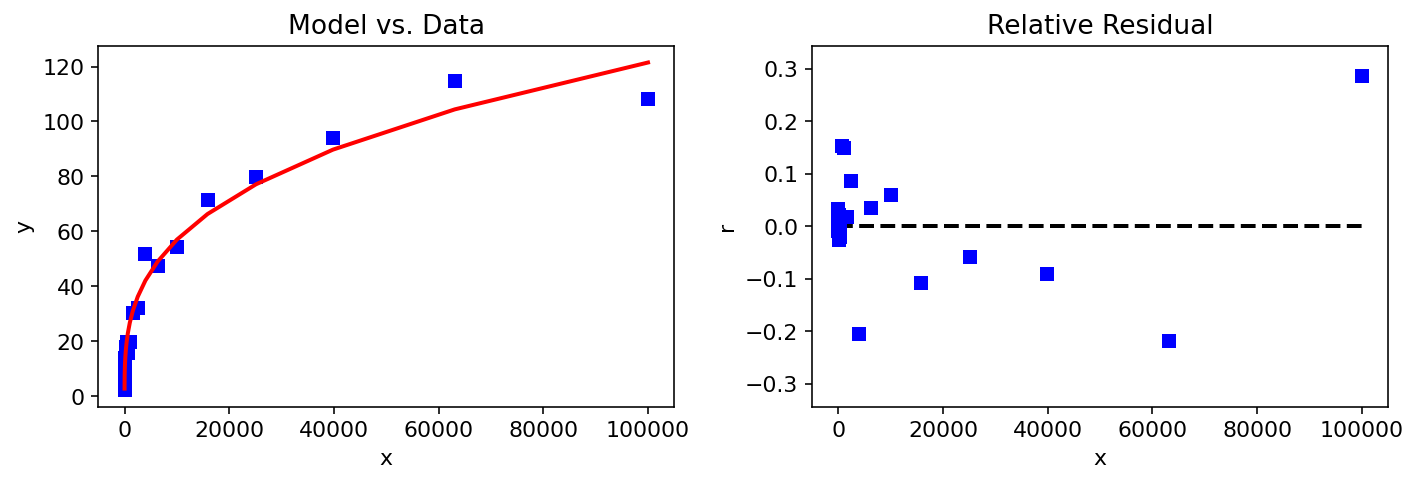

Parameter Values: 95%

   a =   2.765729 +- 0.777158
   b =   0.328521 +- 0.027220

absolute r-squared: 0.98114469  (1.72 nines)
adjusted r-squared: 0.98035905  (1.71 nines)




In [8]:
def powerlaw(x, a, b):
    return a * x ** b

nlguess = [10**linfit[0], linfit[1]]  #guesses obtained from previous cell
nlinfit, nlerr = classlib4334.fit_and_plot(powerlaw, x1, y1)

a_nlin = nlinfit[0]
b_nlin = nlinfit[1]

And for completeness, let's now compare the logarithms of the data to the logarithms of the model (i.e. the reverse of what we did above).

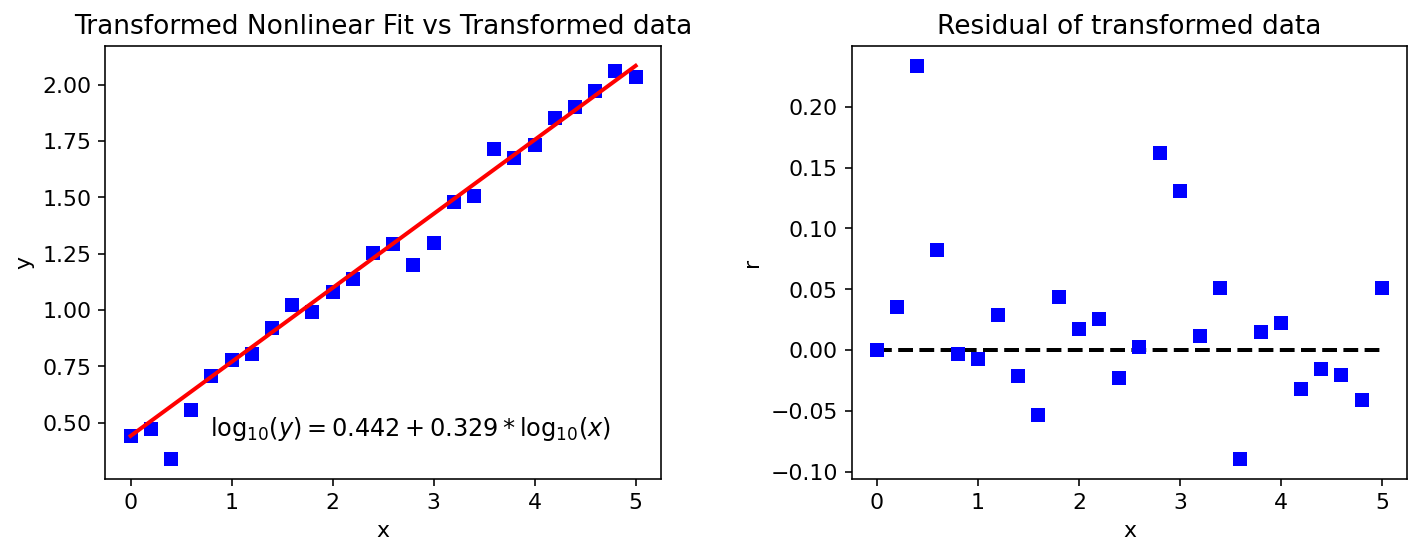

In [9]:
a_n2l = np.log10(a_nlin)
typ_n2l = a_n2l + b_nlin*tx1
ypred_string = r"$\log_{10}(y) = %1.3f + %1.3f * \log_{10}(x)$" % (a_n2l, b_nlin)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(tx1, ty1, 'bs')
plt.plot(tx1, typ_n2l, 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Transformed Nonlinear Fit vs Transformed data')
plt.text(0.55, 0.1, ypred_string, {'size':12}, horizontalalignment="center", transform=plt.gca().transAxes)

plt.subplot(122)
plt.plot(tx1,0*tx1, 'k--')
plt.plot(tx1, typ_n2l-ty1, 'bs')
plt.xlabel('x')
plt.ylabel('r')
plt.title(r'Residual of transformed data')

plt.tight_layout()
plt.show()


# Comparison and Discussion

So, fitting the transformed data to a line gives a final model of 

$y = 10^{0.389} x^{0.340} = 2.45 x^{0.340}$

whereas fitting the actual data to a power law gives a final model of 

$y = 2.766 x^{0.328}$

It isn't necessarily obvious which model is "better," but the issue of noise is important.  If the noise is **additive**, then it is typically best to fit the original data to a nonlinear model.  However, if the noise is **multiplicative**, then it typically makes more sense to fit the transformed data to a line.  This is because logarithms convert multiplication to addition.

One final, potential refinement is possible if we notice that both exponents are very close to 1/3.  Many physical systems in nature follow simple power laws.  So suppose that we suspect this data obeys a power law with exponent equal to exactly 1/3.  Let's try one more fit and see what pre-factor we obtain

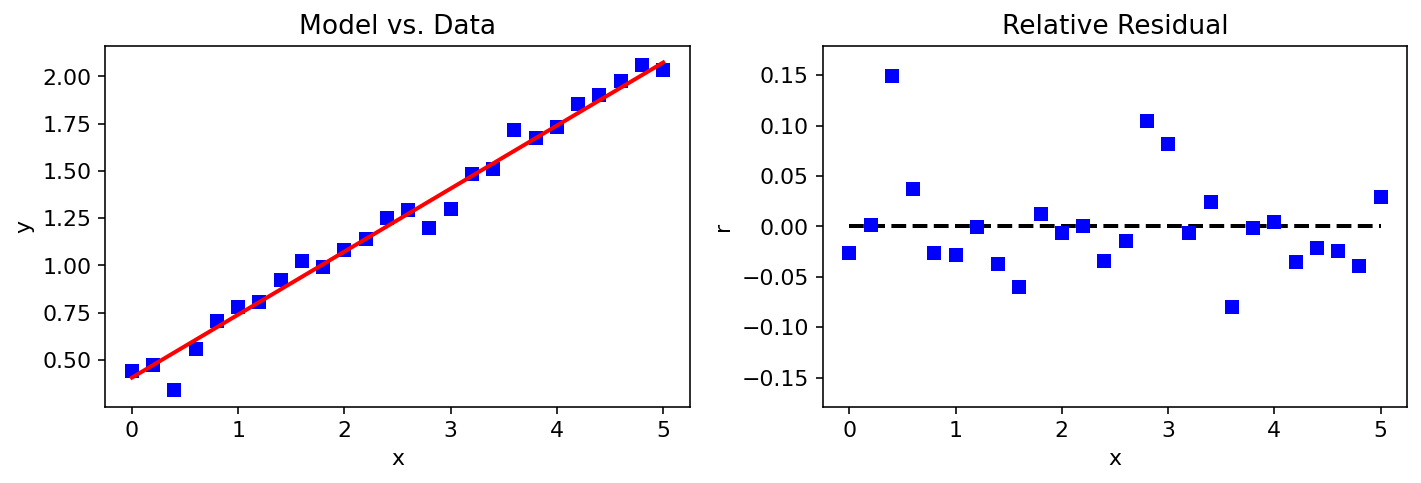

Parameter Values: 95%

   a =   0.406354 +- 0.026169

absolute r-squared: 0.98384064  (1.79 nines)
adjusted r-squared: 0.98384064  (1.79 nines)


F-test comparing line13 (simple) vs. line (complex)

  F-number: 0.6450 
  P-value:  0.4298 
  Random?   42.978%

It is recommended to prefer the simple function.



In [10]:
def line13(x, a):
    return a + x/3

l13fit, l13err = classlib4334.fit_and_plot(line13, tx1, ty1, p0=[.5])

fnum, pval = classlib4334.compare_nested(tx1, ty1, line13, line)


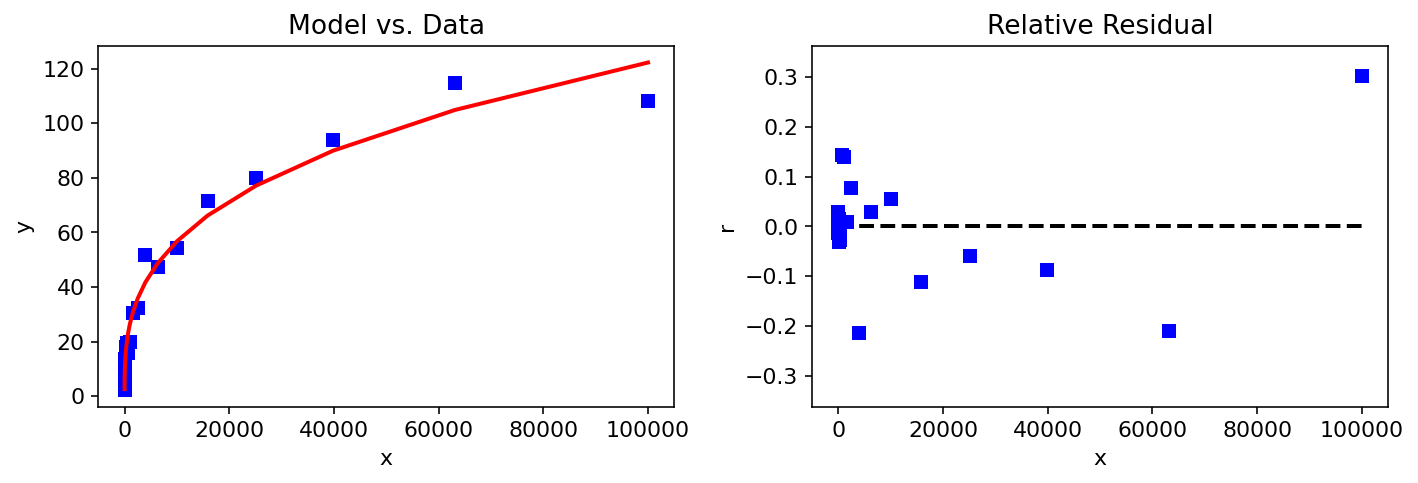

Parameter Values: 95%

   a =   2.632859 +- 0.105469

absolute r-squared: 0.98104237  (1.72 nines)
adjusted r-squared: 0.98104237  (1.72 nines)


F-test comparing power13 (simple) vs. powerlaw (complex)

  F-number: 0.1302 
  P-value:  0.7213 
  Random?   72.134%

It is recommended to prefer the simple function.



In [12]:
def power13(x, a):
    return a*x**(1./3.)

p13fit, p13err = classlib4334.fit_and_plot(power13, x1, y1, p0=[2.5])

fnum, pval = classlib4334.compare_nested(x1, y1, power13, powerlaw)


### Comparison

Here, fitting the transformed data to a line gives a final model of 

$y = 10^{0.40635} x^{0.333} = 2.55 x^{0.333}$

whereas fitting the actual data to a power law gives a final model of 

$y = 2.633 x^{0.333}$

Note that these are much closer together than when the power was also a free parameter!


In this situation, even if I didn't know the source function ahead of time, I would probably select this as my preferred model, ***even though it has a slightly higher error than the fully nonlinear fit***.  By forcing the exponent to take a simple value near the "optimized" values obtained above, I would be most hopeful that my model could be derived from some physical law, and I would also have the most confidence in the pre-factor.

For reference, the function I used to generated this data was
$$y = 2.6 x^{0.333} (1 + \eta(0.1))$$

(note the multiplicative noise!)  Both the linear fit of the transformed data, and the nonlinear fit of the original data, gave something pretty close to this result. Interestingly, the linear fit of the transformed data seems to have gotten us a bit closer to the function used to create the data in the first place.

